<a href="https://colab.research.google.com/github/mao1756/CAP5619-sp24/blob/main/HW1/codes/q3main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q3 Notebook

In [2]:
!wget http://www.cs.fsu.edu/~liux/courses/deepRL/assignments/hw2_softmax_weights.m
!apt install octave
!pip install octave_kernel
!pip install oct2py

--2024-02-07 01:29:52--  http://www.cs.fsu.edu/~liux/courses/deepRL/assignments/hw2_softmax_weights.m
Resolving www.cs.fsu.edu (www.cs.fsu.edu)... 128.186.122.19
Connecting to www.cs.fsu.edu (www.cs.fsu.edu)|128.186.122.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32538 (32K) [application/vnd.wolfram.mathematica.package]
Saving to: ‘hw2_softmax_weights.m’

hw2_softmax_weights 100%[===================>]  31.78K   143KB/s    in 0.2s    

2024-02-07 01:29:53 (143 KB/s) - ‘hw2_softmax_weights.m’ saved [32538/32538]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aglfn default-jre-headless epstool fonts-droid-fallback fonts-freefont-otf fonts-noto-mono
  fonts-urw-base35 ghostscript gnuplot-data gnuplot-qt gsfonts imagemagick-6-common info
  install-info libamd2 libauthen-sasl-perl libbtf1 libcamd2 libccolamd2 libcholmod3 libclone-perl
  libcolamd2 libcombb

In [3]:
# save weights
from oct2py import octave as oct
oct.eval('run hw2_softmax_weights.m')
oct.eval("save -v7 weights.mat")

In [46]:
# load weights using scipy
import scipy.io as sio
weights = sio.loadmat('weights.mat')
bias = weights['softmax_bias']
weights = weights['softmax_weight']

#Q1

In [47]:
# check the shapes
print(bias.shape)
print(weights.shape)

(1, 20)
(100, 20)


# Q2

In [6]:
# import the samples
!wget http://www.cs.fsu.edu/~liux/courses/deepRL/assignments/hw2_softmax_sample.txt
oct.eval('run hw2_softmax_sample.txt')
oct.eval("save -v7 sample.mat")
sam = sio.loadmat('sample.mat')
sample = sam['asample'].reshape(-1)

--2024-02-07 01:31:19--  http://www.cs.fsu.edu/~liux/courses/deepRL/assignments/hw2_softmax_sample.txt
Resolving www.cs.fsu.edu (www.cs.fsu.edu)... 128.186.122.19
Connecting to www.cs.fsu.edu (www.cs.fsu.edu)|128.186.122.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662 [text/plain]
Saving to: ‘hw2_softmax_sample.txt’

hw2_softmax_sample. 100%[===================>]     662  --.-KB/s    in 0s      

2024-02-07 01:31:20 (131 MB/s) - ‘hw2_softmax_sample.txt’ saved [662/662]



3


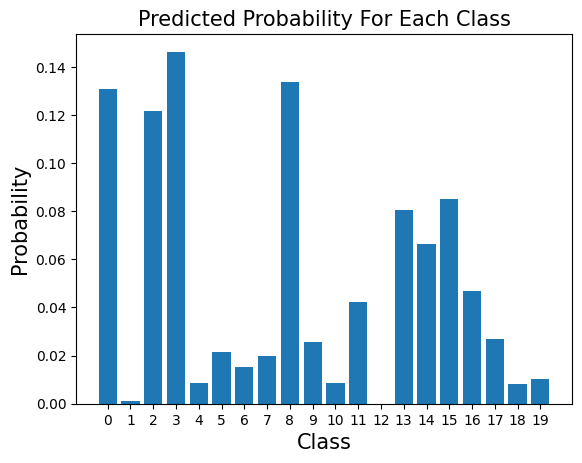

In [48]:
import torch

class Softmax(torch.nn.Module):
  def __init__(self, weights, bias):
    super(Softmax, self).__init__()
    self.linear = torch.nn.Linear(weights.shape[0], weights.shape[1])
    self.linear.weight = torch.nn.Parameter(torch.tensor(weights.T))
    self.linear.bias = torch.nn.Parameter(torch.tensor(bias.flatten()))
    self.softmax = torch.nn.Softmax(dim=0)

  def forward(self, x):
    x = self.linear(x)
    x = self.softmax(x)
    return x

# define the model
model_softmax = Softmax(weights, bias)

# forward pass
outputs = model_softmax(torch.tensor(sample))

# classify the sample
predictions = torch.argmax(outputs)
predictions = predictions.numpy()
print(predictions)

# bar graph for probabilities of each class
import matplotlib.pyplot as plt
plt.xticks(range(20))
plt.xlabel('Class', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title('Predicted Probability For Each Class', fontsize=15)
plt.bar(range(20), outputs.detach().numpy())
plt.savefig('q4-2.png')
plt.show()

#Q3

In [8]:
opt = torch.optim.SGD(model_softmax.parameters(), lr=0.1)
opt.zero_grad()
loss = -torch.log(outputs[5]) # cross_entopy
loss.backward()
opt.step()


# check how many weights and biases incread/decreased/same
# increased weights
print((model_softmax.linear.weight-torch.tensor(weights.T)>0.00001).sum())
# decreased weights
print((model_softmax.linear.weight-torch.tensor(weights.T)<-0.00001).sum())
# same weights
print(((model_softmax.linear.weight-torch.tensor(weights.T)<0.00001)
& (model_softmax.linear.weight-torch.tensor(weights.T)>-0.00001)).sum())

# increased bias
print(sum(model_softmax.linear.bias-torch.tensor(bias.flatten())>0.00001))
# decreased bias
print(sum(model_softmax.linear.bias-torch.tensor(bias.flatten())<-0.00001))
# same weights
print(sum((model_softmax.linear.bias-torch.tensor(bias.flatten())<0.00001 )
& (model_softmax.linear.bias-torch.tensor(bias.flatten())>-0.00001)))


tensor(10)
tensor(180)
tensor(1810)
tensor(1)
tensor(18)
tensor(1)


# Q4

In [15]:
from scipy.optimize import fmin_l_bfgs_b
import numpy as np

def func_to_optimize(dx):
  outputs = model_softmax(torch.tensor(sample+dx))
  loss = np.linalg.norm(dx)**2 - torch.log(outputs[5]).cpu().detach().numpy()
  return loss.item()

# solve the optimization problem to find an adversarial example
dx, f, d = fmin_l_bfgs_b(func_to_optimize, np.zeros(sample.shape), maxiter=1000, approx_grad=True)

5


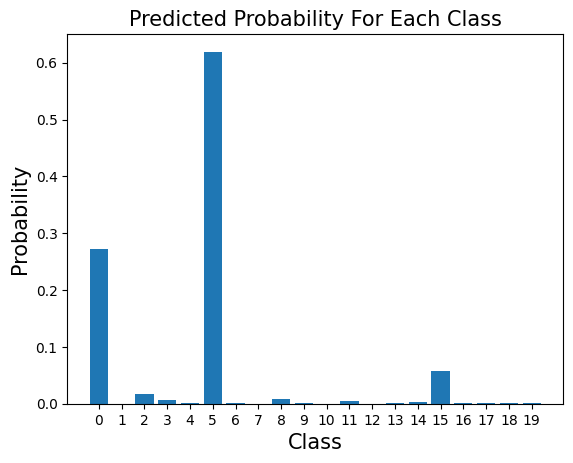

In [30]:
# forward pass
outputs = model_softmax(torch.tensor(sample+dx))

# classify the sample
predictions = torch.argmax(outputs)
predictions = predictions.numpy()
print(predictions) # it should output 5

# bar graph for probabilities of each class
import matplotlib.pyplot as plt
plt.xticks(range(20))
plt.xlabel('Class', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title('Predicted Probability For Each Class', fontsize=15)
plt.bar(range(20), outputs.detach().numpy())
plt.savefig('q4-4.png')
plt.show()

In [32]:
print(dx)
print(np.linalg.norm(dx))

[-1.29430876e-01  4.85392840e-02 -4.32794816e-02  5.16512796e-02
  3.43067937e-02 -1.09486918e-02  1.99982815e-01  6.83905166e-02
  1.51717139e-01 -6.81164048e-03 -6.71549980e-02  7.39439236e-02
 -6.86610298e-03 -2.77316211e-02  1.53982826e-01 -1.83273342e-02
 -1.26057532e-01 -9.63158658e-03 -9.60485308e-03 -3.08632653e-02
  9.12763894e-03  3.26583207e-03 -4.77158059e-03 -1.06074515e-02
  3.69430990e-02 -4.22596852e-02  8.98072498e-02 -4.91518563e-02
 -5.86485183e-02  1.05097401e-01  1.24223140e-01 -1.16915606e-01
  1.03551413e-01  2.96667351e-01  4.07858556e-02  6.49484614e-02
 -1.19554437e-04  1.98484939e-02 -1.01552565e-02  7.77525365e-02
 -6.82398588e-02 -3.92046852e-02  7.54200111e-02  1.54473664e-02
  7.11844329e-03  6.18968544e-02 -3.92946406e-02 -5.67286111e-02
  9.97113411e-02 -3.78808584e-02  4.64455496e-02 -2.01016558e-02
  1.23223948e-01  6.53822251e-02 -1.40870883e-03 -4.51702056e-02
 -1.05555063e-03  4.31990649e-02 -1.86989467e-02  1.85139490e-02
  2.08154876e-01 -9.35145

# Q5

In [100]:
import numpy as np
from scipy.optimize import linprog

# Define the linear programming coefficients as defined in the pdf

# Construct c
c = np.zeros(101)
c[-1] = 1

# Construct A
w_diff = weights - weights[:, 5:6]
A_top = np.hstack([w_diff.T, np.zeros((20, 1))])
identity_matrix = np.eye(100)
A_middle = np.hstack([identity_matrix, -np.ones((100, 1))])
A_bottom = np.hstack([-identity_matrix, -np.ones((100, 1))])
A = np.vstack([A_top, A_middle, A_bottom])

# Construct u
bias_flat = bias.flatten()
b_diff = bias_flat - bias_flat[5]
u_top = - b_diff - w_diff.T @ sample
u = np.hstack([u_top, np.zeros(200)])

# Solve the linear programming problem
result = linprog(c, A_ub=A, b_ub=u, method='highs-ipm')

if result.success:
    print("Optimal value:", result.fun)
    print("Optimal Δx:", result.x[:-1])
    print("Optimal t:", result.x[-1])
else:
    print("Optimization failed:", result.message)

Optimal value: 0.11109915196744699
Optimal Δx: [0.         0.11109915 0.         0.11109915 0.11109915 0.
 0.11109915 0.11109915 0.11109915 0.11109915 0.         0.11109915
 0.         0.         0.11109915 0.         0.         0.11109915
 0.         0.         0.11109915 0.         0.         0.
 0.11109915 0.         0.11109915 0.         0.         0.11109915
 0.11109915 0.         0.11109915 0.11109915 0.11109915 0.11109915
 0.         0.         0.11109915 0.11109915 0.         0.
 0.11109915 0.11109915 0.11109915 0.11109915 0.         0.
 0.11109915 0.         0.11109915 0.         0.11109915 0.11109915
 0.         0.         0.11109915 0.11109915 0.         0.
 0.11109915 0.11109915 0.11109915 0.11109915 0.         0.
 0.         0.         0.11109915 0.11109915 0.11109915 0.
 0.         0.         0.11109915 0.         0.         0.11109915
 0.11109915 0.         0.11109915 0.11109915 0.11109915 0.
 0.         0.11109915 0.         0.         0.         0.
 0.         0.111099

0


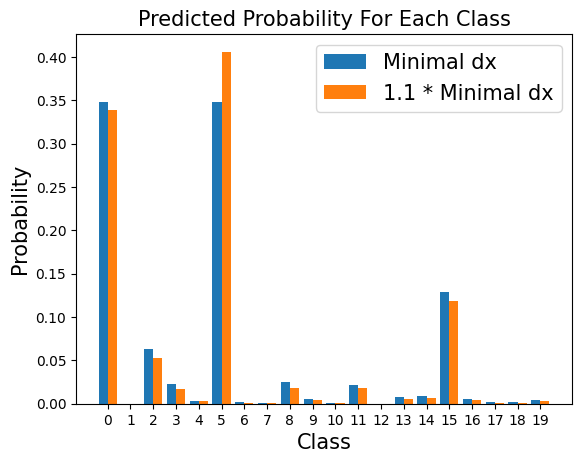

In [114]:
# forward pass
outputs = model_softmax(torch.tensor(sample+result.x[:-1]))
outputs11 = model_softmax(torch.tensor(sample+1.1*result.x[:-1]))

# classify the sample
predictions = torch.argmax(outputs)
predictions = predictions.numpy()
print(predictions) # it should output 5

# bar graph for probabilities of each class
import matplotlib.pyplot as plt
width = 0.4
plt.xticks(range(20))
plt.xlabel('Class', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title('Predicted Probability For Each Class', fontsize=15)
plt.bar(np.array(range(20))-width/2, outputs.detach().numpy(), width=width, label = 'Minimal dx')
plt.bar(np.array(range(20))+width/2, outputs11.detach().numpy(), width=width, label='1.1 * Minimal dx')
plt.legend(fontsize=15)
plt.savefig('q4-5.png')
plt.show()